In [178]:
import networkx as nx
import pandas as pd

In [179]:
edges = pd.read_csv("../../preds1100/network.tsv", sep="\t")

In [180]:
G = nx.from_pandas_edgelist(edges, source="source", target="target", edge_attr="rel", create_using=nx.DiGraph())

# Add node properties
source_ner_dict = edges.set_index('source')['source_ner'].to_dict()
target_ner_dict = edges.set_index('target')['target_ner'].to_dict()

for node in G.nodes():
    G.nodes[node]['ner'] = source_ner_dict.get(node, target_ner_dict.get(node, None))

In [181]:
# Calculate degree for all nodes that have the 'INHABITS' rel type edge
inhabits_edges = [(u, v) for u, v, d in G.edges(data=True) if d['rel'] == 'INHABITS']
inhabits_nodes = set([u for u, v in inhabits_edges] + [v for u, v in inhabits_edges])

# Create a subgraph with only 'INHABITS' edges
inhabits_G = G.edge_subgraph(inhabits_edges).copy()

# Calculate degree for each node in the subgraph
inhabits_degrees = dict(inhabits_G.degree(inhabits_nodes))

# Sort nodes by degree in descending order
sorted_inhabits_degrees = sorted(inhabits_degrees.items(), key=lambda item: item[1], reverse=True)

# Print the top degree nodes
top_n = 100  # Number of top nodes to display
print(f"Top {top_n} nodes with highest degrees for 'INHABITS' rel type edge:")
for node, degree in sorted_inhabits_degrees[:top_n]:
    print(f"Node: {node}, Degree: {degree}")

Top 100 nodes with highest degrees for 'INHABITS' rel type edge:
Node: human, Degree: 1123
Node: plant, Degree: 303
Node: mouse, Degree: 266
Node: rice, Degree: 265
Node: chicken, Degree: 257
Node: pig, Degree: 231
Node: patient, Degree: 228
Node: soil, Degree: 204
Node: tomato, Degree: 202
Node: wheat, Degree: 194
Node: maize, Degree: 158
Node: dog, Degree: 145
Node: potato, Degree: 144
Node: fish, Degree: 137
Node: bovine, Degree: 128
Node: year, Degree: 126
Node: t__468063, Degree: 125
Node: cattle, Degree: 125
Node: hot spring, Degree: 93
Node: soybean, Degree: 89
Node: rat, Degree: 87
Node: poultry, Degree: 87
Node: infant, Degree: 85
Node: t__132830, Degree: 85
Node: fungal, Degree: 74
Node: swine, Degree: 72
Node: sheep, Degree: 69
Node: tomato plants, Degree: 68
Node: sponge, Degree: 66
Node: sugarcane, Degree: 66
Node: t__12278, Degree: 62
Node: pepper, Degree: 62
Node: blood of, Degree: 59
Node: contaminated soil, Degree: 59
Node: cucumber, Degree: 58
Node: tobacco, Degree: 5

In [182]:
# Find all nodes with ner=STRAIN that are connected to "human" with INHABITS edge
environment = "rice"
strain_nodes_connected_to_human = [
    node for node in G.nodes()
    if G.nodes[node].get('ner') == 'STRAIN' and
    G.has_edge(node, environment) and
    G[node][environment]['rel'] == 'INHABITS'
]

print(f"Number of STRAIN nodes connected to '{environment}' with INHABITS edge: {len(strain_nodes_connected_to_human)}")
print("First few nodes in the list:")
print(strain_nodes_connected_to_human[:5])  # Print first 5 nodes as an example


Number of STRAIN nodes connected to 'rice' with INHABITS edge: 265
First few nodes in the list:
['t__774225', 't__36311', 't__90481', 't__227899', 't__121681']


In [183]:
# Filter the network for nodes that have the label STRAIN (connected to human) and COMPOUND in ner node property
# Also filter edges that are "GROWS_ON" and "SYMBIONT_OF"
filtered_nodes = [
    node for node, data in G.nodes(data=True) 
    if (data.get('ner') == 'STRAIN' and node in strain_nodes_connected_to_human) or data.get('ner') == 'COMPOUND'
]
filtered_G = G.subgraph(filtered_nodes).copy()

# Remove edges with "GROWS_ON" and "SYMBIONT_OF" relationships
edges_to_remove = [(u, v) for u, v, data in filtered_G.edges(data=True) 
                   if data['rel'] in ['GROWS_ON', 'SYMBIONT_OF', "INHABITS", "PROMOTES", "INFECTS", "PRESENTS","ASSOCIATED_WITH"]]
filtered_G.remove_edges_from(edges_to_remove)

In [184]:
# Get all types of edges in the filtered network
edge_types = set()
for _, _, data in filtered_G.edges(data=True):
    edge_types.add(data['rel'])

print("Types of edges in the filtered network:")
for edge_type in sorted(edge_types):
    print(f"- {edge_type}")

# Count the occurrences of each edge type
edge_type_counts = {}
for _, _, data in filtered_G.edges(data=True):
    edge_type = data['rel']
    edge_type_counts[edge_type] = edge_type_counts.get(edge_type, 0) + 1

print("\nEdge type counts:")
for edge_type, count in sorted(edge_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{edge_type}: {count}")


Types of edges in the filtered network:
- DEGRADES
- INHIBITS
- PRODUCES
- RESISTS

Edge type counts:
PRODUCES: 1749
INHIBITS: 247
RESISTS: 188
DEGRADES: 140


In [185]:
# Drop nodes that don't have an edge
filtered_G.remove_nodes_from(list(nx.isolates(filtered_G)))

# Calculate the number of edges and nodes for filtered_G after dropping isolated nodes
num_edges = filtered_G.number_of_edges()
num_nodes = filtered_G.number_of_nodes()

print(f"Number of edges in filtered_G: {num_edges}")
print(f"Number of nodes in filtered_G: {num_nodes}")


Number of edges in filtered_G: 2324
Number of nodes in filtered_G: 1735


Text(0.5, 1.0, 'Filtered Network Visualization')

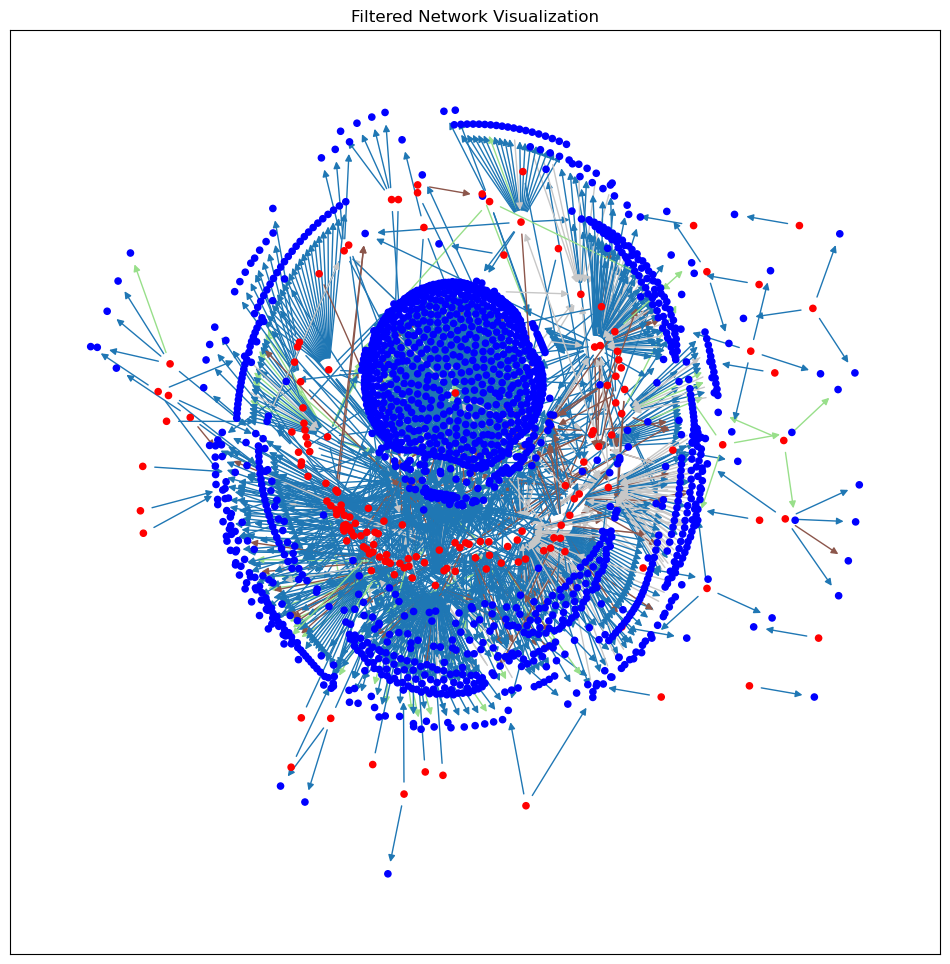

In [186]:
import matplotlib.pyplot as plt

# Define colors for node types
node_color_map = {
    'STRAIN': 'red',
    'COMPOUND': 'blue',
}

# Define colors for edge types dynamically based on the edge types present in the network
unique_edge_types = set(data['rel'] for _, _, data in filtered_G.edges(data=True))
edge_color_map = {edge_type: plt.cm.tab20(i / len(unique_edge_types)) for i, edge_type in enumerate(unique_edge_types)}

# Get node colors based on 'ner' property
node_colors = [node_color_map.get(data['ner'], 'gray') for node, data in filtered_G.nodes(data=True)]

# Get edge colors based on 'rel' property
edge_colors = [edge_color_map.get(data['rel'], 'gray') for u, v, data in filtered_G.edges(data=True)]

# Draw the network
plt.figure(figsize=(12, 12))
pos = nx.nx_agraph.graphviz_layout(filtered_G)  # positions for all nodes

nx.draw_networkx_nodes(filtered_G, pos, node_color=node_colors, node_size=20)  # Reduced node size from 50 to 20
nx.draw_networkx_edges(filtered_G, pos, edge_color=edge_colors, arrows=True)
# Remove node labels to not show the names of the nodes
nx.draw_networkx_labels(filtered_G, pos, font_size=8, labels={})

plt.title("Filtered Network Visualization")


In [187]:
import networkx as nx
from itertools import combinations

def count_specific_triad_patterns(G):
    triad_patterns_count = {}
    strain_nodes = [node for node in G.nodes() if node.startswith('t__')]
    compound_nodes = [node for node in G.nodes() if not node.startswith('t__')]
    
    for strain1, strain2 in combinations(strain_nodes, 2):
        for compound in compound_nodes:
            if G.has_edge(strain1, compound) and G.has_edge(strain2, compound):
                edge1 = G[strain1][compound]
                edge2 = G[strain2][compound]
                pattern = tuple(sorted([(strain1, compound, edge1['rel']), (strain2, compound, edge2['rel'])]))
                
                if pattern in triad_patterns_count:
                    triad_patterns_count[pattern] += 1
                else:
                    triad_patterns_count[pattern] = 1

    return triad_patterns_count

# Count the types of triad patterns in filtered_G
triad_counts = count_specific_triad_patterns(filtered_G)
print("Triad pattern counts (only triads with different strains):")
for pattern, count in triad_counts.items():
    print(f"{pattern}: {count}")

Triad pattern counts (only triads with different strains):
(('t__168637', 'lignin', 'DEGRADES'), ('t__631633', 'lignin', 'PRODUCES')): 1
(('t__168637', 'hemicellulose', 'DEGRADES'), ('t__631633', 'hemicellulose', 'PRODUCES')): 1
(('t__168637', 'cellulose', 'DEGRADES'), ('t__631633', 'cellulose', 'PRODUCES')): 1
(('t__168637', 'cellulose', 'DEGRADES'), ('t__590500', 'cellulose', 'PRODUCES')): 1
(('t__104823', 'cellulose', 'PRODUCES'), ('t__168637', 'cellulose', 'DEGRADES')): 1
(('t__168637', 'cellulose', 'DEGRADES'), ('t__91987', 'cellulose', 'PRODUCES')): 1
(('t__168637', 'cellulose', 'DEGRADES'), ('t__36311', 'cellulose', 'PRODUCES')): 1
(('t__168637', 'aromatic', 'PRODUCES'), ('t__278968', 'aromatic', 'DEGRADES')): 1
(('t__168637', 'cellulose', 'DEGRADES'), ('t__97765', 'cellulose', 'PRODUCES')): 1
(('t__168637', 'furfural', 'PRODUCES'), ('t__61831', 'furfural', 'RESISTS')): 1
(('t__168637', 'lignin', 'DEGRADES'), ('t__61831', 'lignin', 'PRODUCES')): 1
(('t__168637', 'guaiacol', 'PRO

In [188]:
# Count all types of connections, independently of the node labels
connection_counts = {}

for pattern, count in triad_counts.items():
    # Extract only the relationship types from each edge in the pattern
    connections = tuple(sorted(edge[2] for edge in pattern))
    
    if connections in connection_counts:
        connection_counts[connections] += count
    else:
        connection_counts[connections] = count

print("Connection type counts:")
for connections, count in connection_counts.items():
    print(f"{connections}: {count}")

connection_counts

Connection type counts:
('DEGRADES', 'PRODUCES'): 46
('PRODUCES', 'RESISTS'): 58
('PRODUCES', 'PRODUCES'): 3060
('DEGRADES', 'DEGRADES'): 9
('RESISTS', 'RESISTS'): 112
('INHIBITS', 'INHIBITS'): 1
('DEGRADES', 'RESISTS'): 1
('INHIBITS', 'PRODUCES'): 1


{('DEGRADES', 'PRODUCES'): 46,
 ('PRODUCES', 'RESISTS'): 58,
 ('PRODUCES', 'PRODUCES'): 3060,
 ('DEGRADES', 'DEGRADES'): 9,
 ('RESISTS', 'RESISTS'): 112,
 ('INHIBITS', 'INHIBITS'): 1,
 ('DEGRADES', 'RESISTS'): 1,
 ('INHIBITS', 'PRODUCES'): 1}

In [189]:
# Classify strain-strain connections based on triad counts
strain_connections = {}

for pattern, count in triad_counts.items():
    strain1, compound, rel1 = pattern[0]
    strain2, _, rel2 = pattern[1]
    
    if strain1.startswith('t__') and strain2.startswith('t__'):
        connection_type = None
        
        # if rel1 == rel2 == 'PRODUCES':
        #     connection_type = 'negative'
        if rel1 == rel2 == 'DEGRADES':
            connection_type = 'negative'
        elif (rel1 == 'PRODUCES' and rel2 == 'DEGRADES') or (rel1 == 'DEGRADES' and rel2 == 'PRODUCES'):
            connection_type = 'positive'
        elif (rel1 == 'PRODUCES' and rel2 == 'INHIBITS') or (rel1 == 'INHIBITS' and rel2 == 'PRODUCES'):
            connection_type = 'negative'
        elif (rel1 == 'PRODUCES' and rel2 == 'RESISTS') or (rel1 == 'RESISTS' and rel2 == 'PRODUCES'):
            connection_type = 'positive'
        
        if connection_type:
            key = tuple(sorted([strain1, strain2]))
            if key not in strain_connections:
                strain_connections[key] = {'positive': 0, 'negative': 0}
            strain_connections[key][connection_type] += count

print("Strain-strain connections:")
for strains, connections in strain_connections.items():
    print(f"{strains}: Positive: {connections['positive']}, Negative: {connections['negative']}")

print(f"Total number of strain-strain connections: {len(strain_connections)}")
print(f"Total number of triad patterns: {len(triad_counts)}")

Strain-strain connections:
('t__168637', 't__631633'): Positive: 3, Negative: 0
('t__168637', 't__590500'): Positive: 1, Negative: 0
('t__104823', 't__168637'): Positive: 1, Negative: 0
('t__168637', 't__91987'): Positive: 1, Negative: 0
('t__168637', 't__36311'): Positive: 1, Negative: 0
('t__168637', 't__278968'): Positive: 1, Negative: 0
('t__168637', 't__97765'): Positive: 1, Negative: 0
('t__168637', 't__61831'): Positive: 4, Negative: 1
('t__168637', 't__652230'): Positive: 1, Negative: 0
('t__61831', 't__631633'): Positive: 2, Negative: 0
('t__148232', 't__602785'): Positive: 1, Negative: 0
('t__602785', 't__652230'): Positive: 1, Negative: 0
('t__61831', 't__96255'): Positive: 1, Negative: 0
('t__384365', 't__61831'): Positive: 3, Negative: 0
('t__361507', 't__702886'): Positive: 1, Negative: 0
('t__104823', 't__61831'): Positive: 1, Negative: 0
('t__583266', 't__61831'): Positive: 1, Negative: 0
('t__45562', 't__74076'): Positive: 0, Negative: 1
('t__430413', 't__61831'): Posi

In [190]:
vertices = pd.read_csv("../../preds1100/strainselect/StrainSelect21_vertices.tab.txt", sep="\t")

In [191]:
def get_strain_id(strain):
    return vertices[(vertices["StrainSelectID"]==strain)&(vertices["vertex_type"]=="gss")].vertex.values[0]

In [192]:
print("Strain-strain connections with strain IDs (sorted by total count, descending):")
sorted_connections = sorted(strain_connections.items(), key=lambda x: sum(x[1].values()), reverse=True)
for strains, connections in sorted_connections:
    strain1_id = get_strain_id(strains[0])
    strain2_id = get_strain_id(strains[1])
    total_count = connections['positive'] + connections['negative']
    print(f"{(strain1_id, strain2_id)}: Positive: {connections['positive']}, Negative: {connections['negative']}, Total: {total_count}")


Strain-strain connections with strain IDs (sorted by total count, descending):
('pseudomonas.putida.atcc.47054', 'bacillus.sp.inv.fir64'): Positive: 6, Negative: 1, Total: 7
('pantoea.ananatis.sd.1', 'pseudomonas.putida.atcc.47054'): Positive: 4, Negative: 1, Total: 5
('pseudomonas.stutzeri.3', 'pseudomonas.putida.atcc.47054'): Positive: 2, Negative: 3, Total: 5
('acetobacter.aceti.lmg.1514', 'pseudomonas.putida.atcc.47054'): Positive: 4, Negative: 0, Total: 4
('pseudomonas.fluorescens.wcs365', 'pseudomonas.putida.atcc.47054'): Positive: 4, Negative: 0, Total: 4
('pantoea.ananatis.sd.1', 'enterococcus.faecalis.fc11682'): Positive: 3, Negative: 0, Total: 3
('paraburkholderia.fungorum.brrh.4', 'pseudomonas.putida.atcc.47054'): Positive: 3, Negative: 0, Total: 3
('pseudomonas.putida.atcc.47054', 'enterococcus.faecalis.fc11682'): Positive: 2, Negative: 0, Total: 2
('azorhizobium.caulinodans.ors.571.lmg.6465', 'azospirillum.baldaniorum.sp245'): Positive: 2, Negative: 0, Total: 2
('burkholde

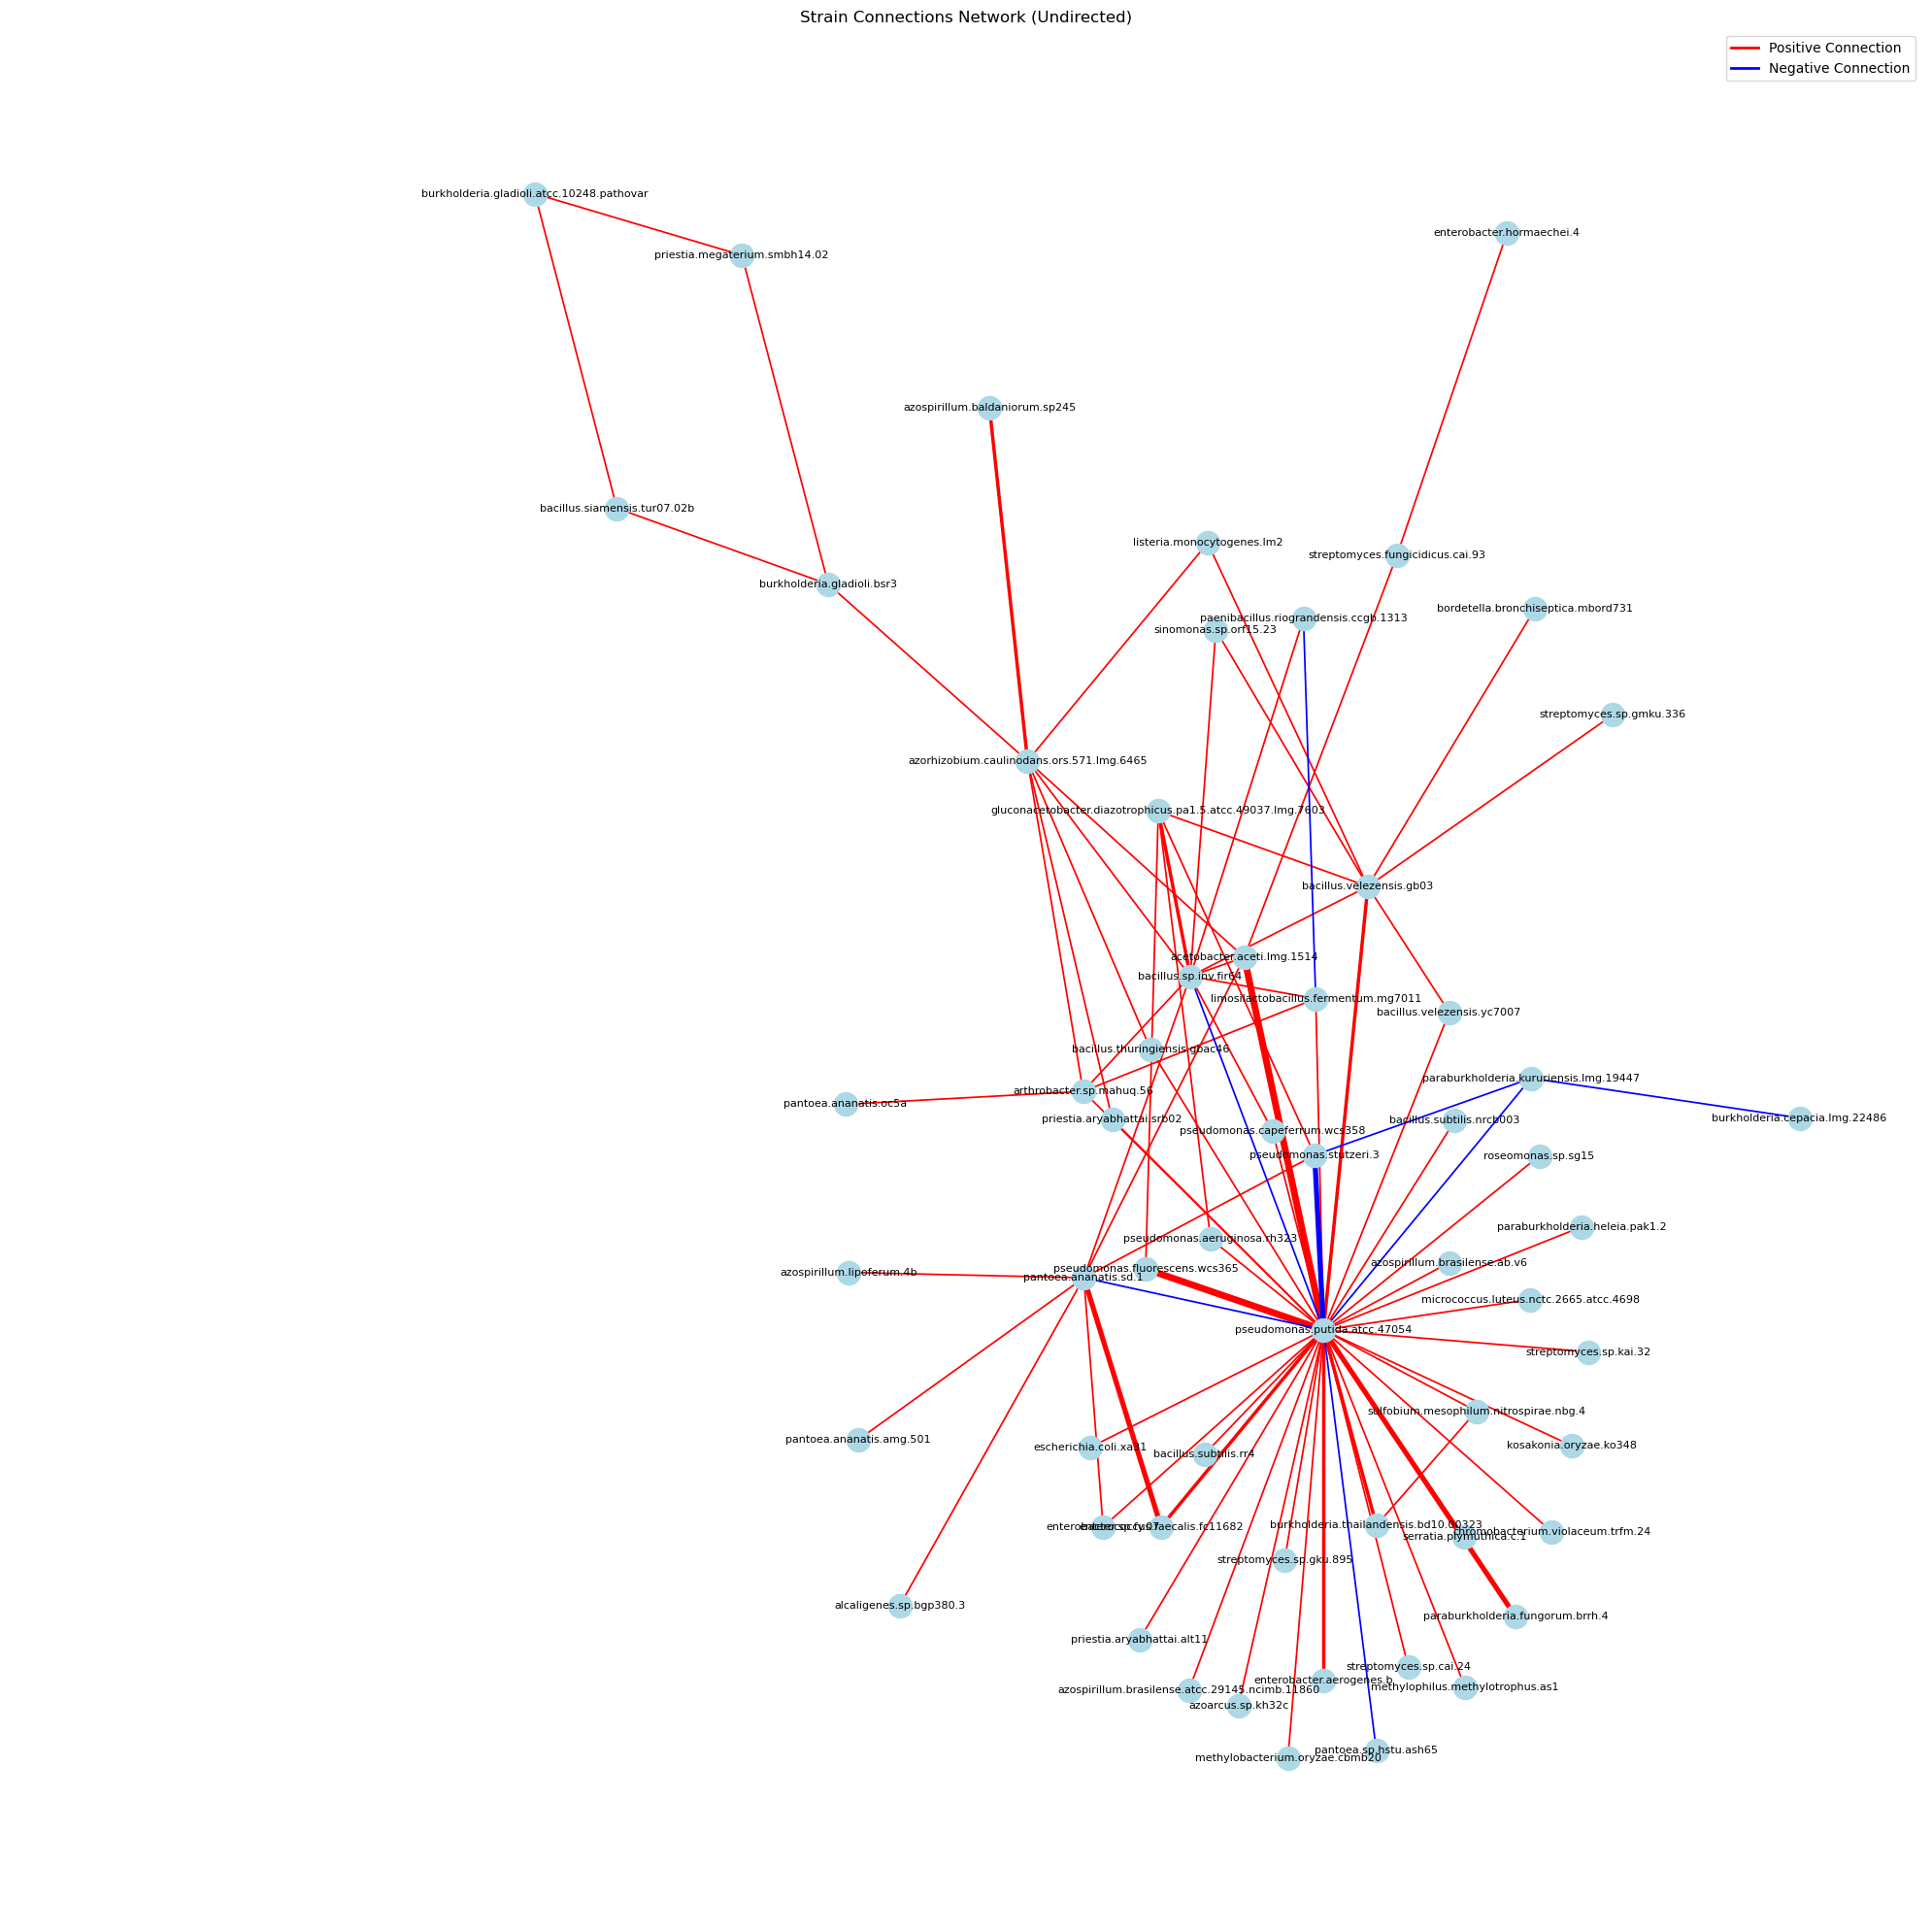

In [193]:
import networkx as nx
import matplotlib.pyplot as plt

# Create an undirected graph
G = nx.Graph()

# Add edges to the graph
for strains, connections in sorted_connections:
    strain1_id = get_strain_id(strains[0])
    strain2_id = get_strain_id(strains[1])
    
    if connections['positive'] > 0:
        G.add_edge(strain1_id, strain2_id, weight=connections['positive'], connection_type='positive')
    
    if connections['negative'] > 0:
        G.add_edge(strain1_id, strain2_id, weight=connections['negative'], connection_type='negative')

# Set up the plot
plt.figure(figsize=(20, 20))

# Define layout
pos = nx.nx_agraph.graphviz_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')

# Draw edges
positive_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['connection_type'] == 'positive']
negative_edges = [(u, v) for (u, v, d) in G.edges(data=True) if d['connection_type'] == 'negative']

all_weights = [G[u][v]['weight'] for (u, v) in G.edges()]
max_weight = max(all_weights)

nx.draw_networkx_edges(G, pos, edgelist=positive_edges, edge_color='r', 
                       width=[G[u][v]['weight']/max_weight*5 for (u, v) in positive_edges])
nx.draw_networkx_edges(G, pos, edgelist=negative_edges, edge_color='b', 
                       width=[G[u][v]['weight']/max_weight*5 for (u, v) in negative_edges])

# Add labels
nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

plt.title("Strain Connections Network (Undirected)")
plt.axis('off')

# Add a legend
plt.plot([0], [0], color='r', label='Positive Connection', linewidth=2)
plt.plot([0], [0], color='b', label='Negative Connection', linewidth=2)
plt.legend()

plt.tight_layout()
